# Livelike Basic Usage Demo

- ACS 2014 - 2019 5-Year Estimates
- UP Baseline Constraints: employment, industry, occupation, education
- Knoxville City, TN PUMA (`4701603`)

## Setup

In [1]:
%load_ext watermark
%watermark

Last updated: 2025-01-31T09:55:48.602146-05:00

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.31.0

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit



In [2]:
import pathlib

import geopandas as gpd
import numpy as np
import pandas as pd
from likeness_vitals.vitals import get_censusapikey, match
from pymedm import PMEDM, diagnostics

from livelike import acs, est, homesim

%watermark -w
%watermark -iv

/Users/41q/gitlab_repos/likeness/likeness-vitals/likeness_vitals/__init__.py:12: FutureWarning: The ``likeness-vitals`` package is transitioning to a modular API for a cleaner top-level namespace. Classes, functions, and attributes that are currently available in the top-level will only be available within their home modules. Both the current and the updated API will be in place for at least two minor releases following the inclusion of this warning. The release at the time of this warning inclusion was ``v1.3.0``, so the current API will be stable until ``v1.5.0`` at the soonest, and the ``v2.0.0`` release will be the absolute deadline. See [https://code.ornl.gov/likeness/likeness-vitals/-/issues/32] for details on how to update dependant packages.
  warnings.warn(


Watermark: 2.5.0

livelike       : 1.4.2
likeness_vitals: 1.4.3.dev6+g2e663aa
pymedm         : 2.1.1.dev4+g785edf4
numpy          : 2.0.2
geopandas      : 1.0.1
pandas         : 2.2.3



### Read Census API Key

In [3]:
key = get_censusapikey(pathlib.Path("..", ""))

### Create baseline PUMA representation

The `puma` class stores a representation of the PUMA based on ACS constraints. It contains the microdata and block group/tract estimates and standard errors required for P-MEDM.

#### Target PUMA - Knoxville City, TN

In [4]:
p = "4701603"

##### Create baseline PUMA representation

In [5]:
pup = acs.puma(p, censusapikey=key)

## Spatial Allocation with P-MEDM

### Create P-MEDM object

**Inputs:**

- ACS vintage year.
- The PUMS household response serial numbers (`serial`).
- The PUMS household sample weights (`wt`)
- Individual-level constraints (`est_ind`)
- Tract and block group level constraints (`est_trt`, `est_bg`)
- Tract and block group level standard errors (`se_trt`, `se_bg`)

In [6]:
pmd = PMEDM(
    pup.year,
    pup.est_ind.index,
    pup.wt,
    pup.est_ind,
    pup.est_g1,
    pup.est_g2,
    pup.se_g1,
    pup.se_g2,
)

### Solve P-MEDM problem

In [7]:
pmd.solve()

In [8]:
# objective value
float(pmd.res.state.value)

-1.5199570129609192

### Diagnostics

As a quick diagnostic, we measure the proportion of synthetic constraint estimates fitting the ACS 90% margins of error (MOEs), or the `moe_fit_rate`:

In [9]:
diagnostics.moe_fit_rate(pup.est_ind, pup.est_g2, pup.se_g2, pmd.almat)

{'Ycomp':                          constraint   acs         pmedm           err    moe  \
 470930001001             population  2463  2.493757e+03  3.075748e+01  227.0   
 470930008001             population  1697  1.735613e+03  3.861284e+01  334.0   
 470930008002             population   574  6.004226e+02  2.642258e+01  235.0   
 470930008003             population  1336  1.379933e+03  4.393273e+01  448.0   
 470930009011             population  1965  1.892172e+03  7.282819e+01  299.0   
 ...                             ...   ...           ...           ...    ...   
 470930070001  hht_nonfam_hhsize_7pm     0  1.165109e-09  1.165109e-09   12.0   
 470930070002  hht_nonfam_hhsize_7pm     0  5.071427e-09  5.071427e-09   12.0   
 470930071001  hht_nonfam_hhsize_7pm     0  7.470038e-19  7.470038e-19   12.0   
 470930071002  hht_nonfam_hhsize_7pm     0  5.401840e-19  5.401840e-19   12.0   
 470930071003  hht_nonfam_hhsize_7pm     0  7.374334e-18  7.374334e-18   12.0   
 
               in

## Population Synthesis

Use Lovelace and Ballas' (2013) "Truncate, Replicate, Sample" method to create 30 realizations of the residential synthetic population:

In [10]:
hs = homesim.synthesize(
    pmd.almat,
    pup.est_ind,
    pup.est_g2,
    pup.sporder,
    random_state=int(pup.fips),
)
hs

,sim,geoid,count
h_id,,,
2015000010209,0,470930001001,1
2015000013399,0,470930001001,1
2015000016188,0,470930001001,1
2015000020218,0,470930001001,2
2015000039553,0,470930001001,1
...,...,...,...
2019HU1295854,29,470930071003,1
2019HU1303896,29,470930071003,2
2019HU1362049,29,470930071003,1


## Application 1: Creating Agents for `actlike`

For this example, we'll focus on tabulating 10th grade public school students. We will identify matching person-level records from the PUMS by querying the Census Microdata API on two criteria:

- Public School Student {`SCH` : 2}
- Attending 10th Grade {`SCHG` : 12}

We set up our API query by separating these conditions with an `&`, as:

In [11]:
# API query
q1 = "SCH=2&SCHG=12"

In [12]:
seg1_extract = acs.extract_pums_segment_ids(p, "person", q1)

Then, create the agents by merging the extract with our synthetic population (`hs`): 

In [13]:
seg1 = hs.merge(
    seg1_extract.loc[:, ["SERIALNO", "p_id"]], left_on="h_id", right_on="SERIALNO"
)
seg1

,sim,geoid,count,SERIALNO,p_id
0,0,470930001001,1,2019HU1036451,2019HU103645102
1,0,470930008001,1,2018HU0602624,2018HU060262402
2,0,470930008002,1,2015000400808,201500040080802
3,0,470930008002,1,2015000487536,201500048753602
4,0,470930008002,1,2015000889349,201500088934904
...,...,...,...,...,...
20827,29,470930071003,1,2017001310689,201700131068902
20828,29,470930071003,1,2018HU0251309,2018HU025130903
20829,29,470930071003,1,2018HU1036109,2018HU103610904
20830,29,470930071003,1,2019HU0146307,2019HU014630702


## Application 2: Tabulating Segments

Sometimes we require more specific criteria to select segments than what is available in our P-MEDM constraints (i.e., occupation class, NAICS code, hours worked). We can fetch additional PUMS variables related to the constraints from the Census Microdata API query and then link them to our synthetic populations.

For this example, we'll estimate the counts of full-time workers in K-12 schools, specifically:

- Employed full time and currently at work (`ESR == 1`)
- Working in elementary or secondary schools (`NAICSP == 6111`)
- In a preschool, kindergarten, primary, or secondary school teaching position (`{OCCP : [2300, 2310, 2320]}`)
- Working 40+ hours per week (`WKHP >= 40`)

Begin by generating the new API query:

In [14]:
q2 = "ESR=1&NAICSP=6111&OCCP=2300:2320&WKHP=40:999"

A `>=` operator does not seem to be availble for CMD API requests, so `40:999` is used in its place.

Now make the API extract:

In [15]:
seg2 = acs.extract_pums_segment_ids(p, "person", q2, censusapikey=key)

This returns a DataFrame containing the household ID (`SERIALNO`) and household structure (`SPORDER`) for each matching respondent in the PUMS:

In [16]:
seg2

,SERIALNO,SPORDER,ESR,NAICSP,OCCP,WKHP,p_id
1,2015000145535,1,1,6111,2310,60,201500014553501
2,2015000238376,1,1,6111,2310,40,201500023837601
3,2015000674050,1,1,6111,2310,40,201500067405001
4,2015000846436,2,1,6111,2320,40,201500084643602
5,2015001439070,2,1,6111,2310,40,201500143907002
...,...,...,...,...,...,...,...
99,2019HU1120059,1,1,6111,2320,40,2019HU112005901
100,2019HU1172652,1,1,6111,2310,40,2019HU117265201
101,2019HU1240260,2,1,6111,2310,40,2019HU124026002
102,2019HU1329436,2,1,6111,2310,50,2019HU132943602


Tabulation:

In [17]:
tab_seg2 = est.tabulate_by_serial(hs, seg2["SERIALNO"], "person")
tab_seg2

sim  geoid       
0    470930001001    26
     470930008001     5
     470930008002     1
     470930008003     7
     470930009022     1
                     ..
29   470930070001     3
     470930070002     2
     470930071001    26
     470930071002    23
     470930071003    12
Length: 3170, dtype: int64

### 2a. Comparing Segment Estimates Across Census Areas

This estimation method is more suited for geodemographic classification (`bundleUP`).  We'll stick with our K-12 educator segment from the previous example here. 

A necessary first step is to **normalize the estimates** to effectively relate census areas. The normalization procedure estimates the _proportion_ of the segment within each block group.  

This one-liner generates the total block group population and household counts by simulation number:

In [18]:
totalpop = est.tabulate_by_count(hs, pup.est_ind["population"])
totalpop

sim  geoid       
0    470930001001    1443.027759
     470930008001     906.748213
     470930008002     444.413767
     470930008003     791.572536
     470930009011     451.527778
                        ...     
29   470930070001     779.288621
     470930070002     819.770560
     470930071001    1063.940702
     470930071002     886.079059
     470930071003     637.091308
Name: population, Length: 3390, dtype: float64

With `totalpop` in hand, we can then normalize the estimates: 

In [19]:
prop_seg2 = est.to_prop(tab_seg2, totalpop)
prop_seg2

sim  geoid       
0    470930001001    0.018018
     470930008001    0.005514
     470930008002    0.002250
     470930008003    0.008843
     470930009022    0.002014
                       ...   
29   470930014001    0.000000
     470930014002    0.000000
     470930014003    0.000000
     470930020003    0.000000
     470930037002    0.000000
Length: 3390, dtype: float64

### 2b. Monte Carlo Estimation

When comparing census areas, it is often more convenient to use estimates that are one-to-one. To achieve this, we can use Monte Carlo estimation to aggregate the simulation-level estimates (as well as gauge uncertainty). 

To generate the Monte Carlo estimates:

In [20]:
mc_prop_seg2 = est.monte_carlo_estimate(prop_seg2)
mc_prop_seg2

,est,se
geoid,,
470930001001,0.018449,0.000287
470930008001,0.005498,0.000032
470930008002,0.002256,0.000025
470930008003,0.008861,0.000051
470930009011,0.000000,0.000000
...,...,...
470930070001,0.003852,0.000026
470930070002,0.002463,0.000013
470930071001,0.025183,0.000495


#### Example 3b: Mapping the Estimates

In [21]:
knox_bg = acs.extract_geographies(2019, targets=pd.unique(hs["geoid"]), geo="bg")

In [22]:
mc_prop_seg2.index.name = "GEOID"

In [23]:
knox_bg["mc_prop_seg2"] = match(knox_bg, mc_prop_seg2.est)

<Axes: >

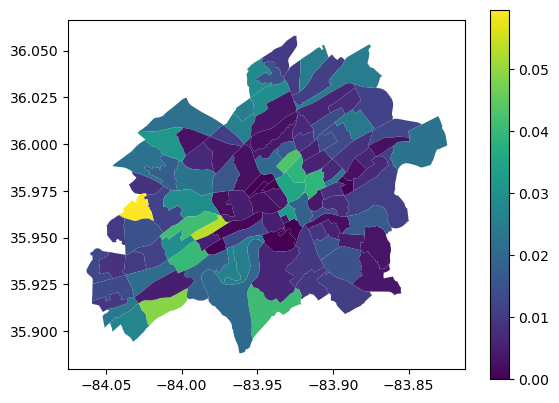

In [24]:
# plot!
knox_bg.plot(column="mc_prop_seg2", legend=True)